In [1]:
import mib as mb1
import mib_v2_3 as mb
import matplotlib.pyplot as plt
import time
from itertools import product
import tracemalloc

# Test 1

## Planteamiento

Comparar rendimiento del mib1.0 contra el mib2.0 con problema pequeño y con tres eventon con distribuciones uniformes.

Se hara el test 100 veces y en cada iteración la cardinalidad de las tres variables crecera en 1, iniciando por cardinalidad de uno.

### Especificación

#### Variables
$A = \{0, 2, ..., n-1\}$

$B = \{0, 2, ..., n-1\}$

$C = \{0, 2, ..., n-1\}$

#### Descomposición de la conjunta
$P(ABC) = P(A)P(B|A)P(C|AB)$

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./P(ABC).jpg" width=200/>

#### Formas
$P(A)$, $P(B|A)$ y $P(C|AB)$ serán distribuciones uniformes.

## Implementación

### MIB 1.0

In [204]:
n = 20
timesM1 = []
memoryM1 = []

timesC1 = []
memoryC1 = []

for i in range(n):
    print(i)
    Events = [x for x in range(i+1)]
    # Varaibles
    A = mb1.Var('A',Events)
    B = mb1.Var('B',Events)
    C = mb1.Var('C',Events)

    dA = {}
    dB_A = {}
    dC_AB = []
    value = 1 / (i+1)
    for e in Events:
        dA[e] = value
        dB_A[e] = {}
        for e1 in Events:
            dB_A[e][e1] = value
            tC_AB = []
            for e2 in Events:
                tC_AB.append(value)
            dC_AB.append(tuple(tC_AB))
    
    PA=mb1.Distrib(name='P(A)',variable=[A],tabla=dA)
    PB_A=mb1.DistribCond(name='P(B|A)',var=B,indep=[A],tabla=dB_A)
    PC_AB=mb1.DistribCond('P(C|AB)',C,[A,B],dC_AB)
    
    PABC=mb1.JointDistrib(name='P(ABC)',variables=[A,B,C],descomp=[PA,PB_A,PC_AB])
    Q_ABC=mb1.Question(joint=PABC)

    #Inferencia de P(B)
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.query(searched=[B])
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesM1.append(tiempo_ejecucion)
    memoryM1.append(memoria_actual / 1000000)
    
    #Inferencia de P(A|BC)
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = Q_ABC.query(searched=[A], known=[B,C])
    fin = time.time() 
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC1.append(tiempo_ejecucion)
    memoryC1.append(memoria_actual / 1000000)
    
import json

# Diccionario que deseas guardar
mi_diccionario = {
    "timesM1": timesM1,
    "timesC1": timesC1,
    "memoryM1": memoryM1,
    "memoryC1": memoryC1
}

# Guardar el diccionario en un archivo JSON
with open("datosMIB1.json", "w") as archivo_json:
    json.dump(mi_diccionario, archivo_json, indent=4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### MIB 2.0

In [221]:
n = 20
timesM = []
memoryM = []
timesC = []
memoryC = []


for i in range(n):
    Events = set([x for x in range(i+1)])
    A = mb.Var('A',Events)
    B = mb.Var('B',Events)
    C = mb.Var('C',Events)
        
    # Generación de distribuciones de probabilidad (Distribuciones uniformes).
    dA = {}
    dB_A = {}
    dC_AB = {}
    value = 1 / (i+1)
    for x in range(i+1):
        dA[(x,)] = value
        dB_A[(x,)] = {}
        for y in range(i+1):
            dB_A[(x,)][(y,)] = value
            dC_AB[(x,y)] = {}
            for z in range(i+1):
                dC_AB[(x,y)][(z,)] = value
        
    PA = mb.Distrib(set([A]),dA, ('A'))
    PB_A = mb.CondDistrib(set([B]),set([A]),dB_A, ('B'), ('A'))
    PC_AB = mb.CondDistrib(set([C]),set([A,B]),dC_AB, ('C'), ('A','B'))
        
    # Probabilidad conjunta (especificación).
    PABC = mb.Specification(set([A,B,C]), set([PA,PB_A,PC_AB]))
        
    # Pregunta para hacer las consultas sobre P(ABC).
    Q_ABC = mb.Question(PABC)
        
    #Inferencia de P(B)
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.DistributionQuery(set([B])) 
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesM.append(tiempo_ejecucion)
    memoryM.append(memoria_actual / 1000000) 
    
    #Inferencia de P(C|AB)
    tracemalloc.start()
    
    inicio = time.time()
    PC_AB = Q_ABC.DistributionQuery(set([C]), set([A,B])) 
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC.append(tiempo_ejecucion)
    memoryC.append(memoria_actual / 1000000) 
import json

# Diccionario que deseas guardar
mi_diccionario = {
    "timesM1": timesM,
    "timesC1": timesC,
    "memoryM1": memoryM,
    "memoryC1": memoryC
}

# Guardar el diccionario en un archivo JSON
with open("datosMIB2.json", "w") as archivo_json:
    json.dump(mi_diccionario, archivo_json, indent=4)

## Datos obtenidos

### Tiempos

#### Tiempos de inferencia para $P(B)$

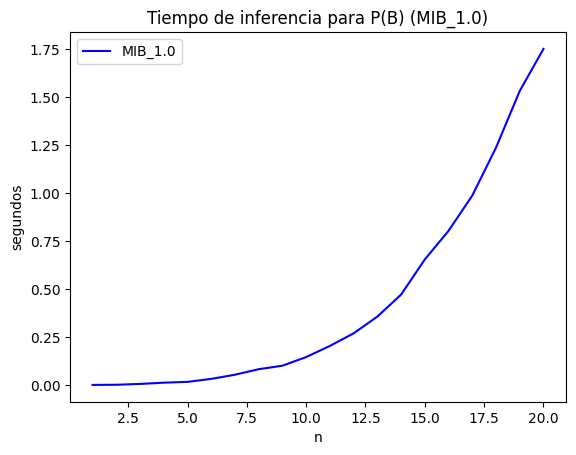

In [222]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesM1, color='b',label = 'MIB_1.0')
ax.set_title("Tiempo de inferencia para P(B) (MIB_1.0)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

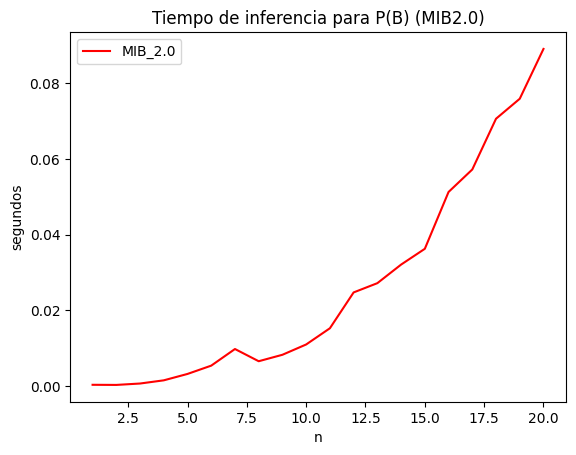

In [223]:
fig, ax = plt.subplots()

# MIB_2.0
ax.plot(xn, timesM, color='r',label = 'MIB_2.0')

ax.set_title("Tiempo de inferencia para P(B) (MIB2.0)")
ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

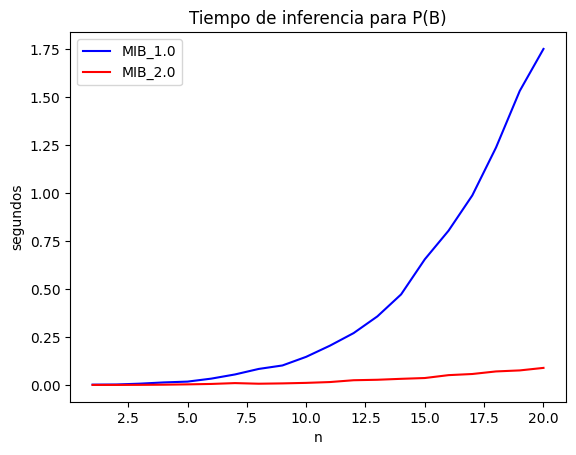

In [224]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesM1, color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesM, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

#### Tiempos de inferencia para $P(C|AB)$

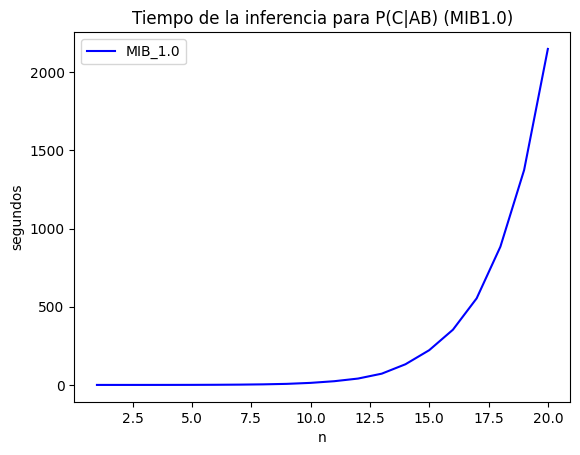

In [225]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesC1, color='b',label = 'MIB_1.0')
ax.set_title("Tiempo de la inferencia para P(C|AB) (MIB1.0)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

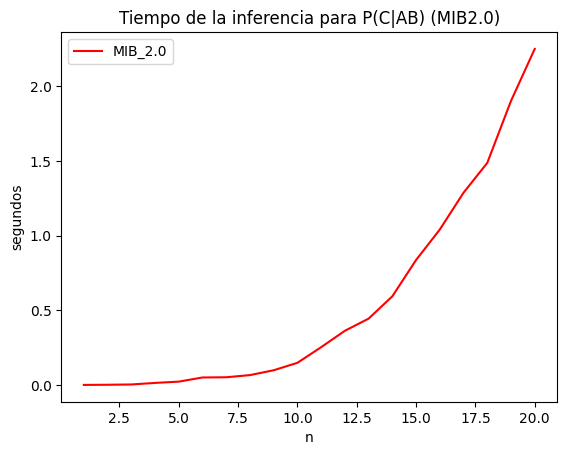

In [226]:
fig, ax = plt.subplots()

# MIB_2.0
ax.plot(xn, timesC, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de la inferencia para P(C|AB) (MIB2.0)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

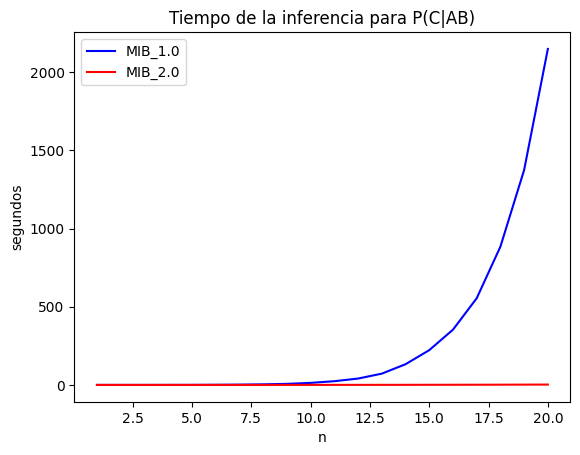

In [227]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesC1, color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesC, color='r',label = 'MIB_2.0')

ax.set_title("Tiempo de la inferencia para P(C|AB)")
ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

### Memoria

#### Memoria para la inferencia de P(B)

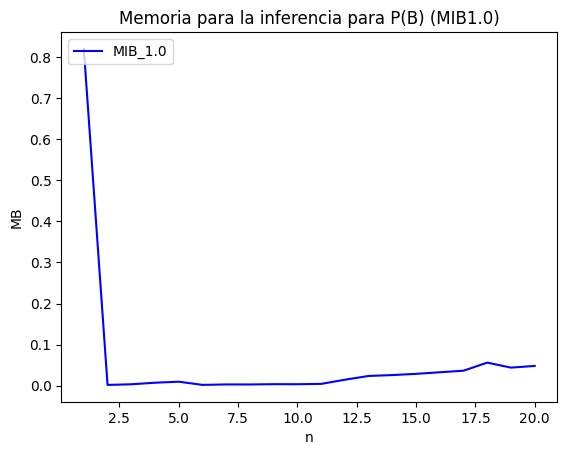

In [228]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, memoryM1, color='b',label = 'MIB_1.0')
ax.set_title("Memoria para la inferencia para P(B) (MIB1.0)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

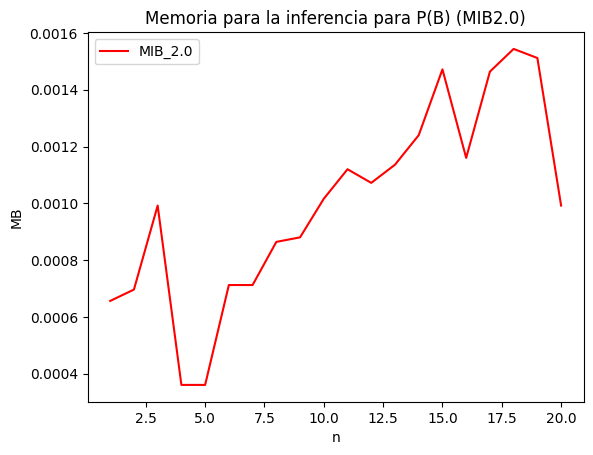

In [229]:
fig, ax = plt.subplots()

# MIB_2.0
ax.plot(xn, memoryM, color='r',label = 'MIB_2.0')
ax.set_title("Memoria para la inferencia para P(B) (MIB2.0)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

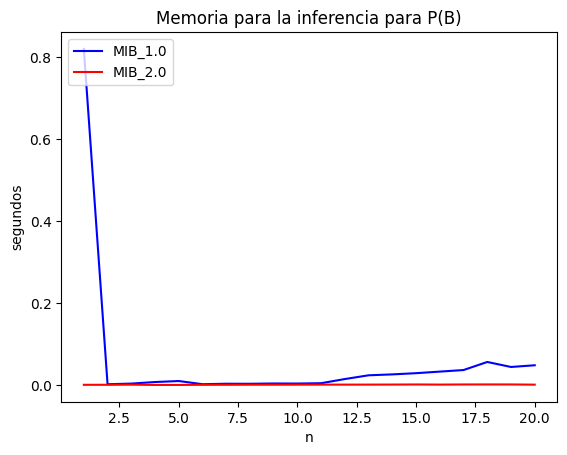

In [230]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, memoryM1, color='b',label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, memoryM, color='r',label = 'MIB_2.0')
ax.set_title("Memoria para la inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

#### Memoria para la inferencia de P(C|AB)

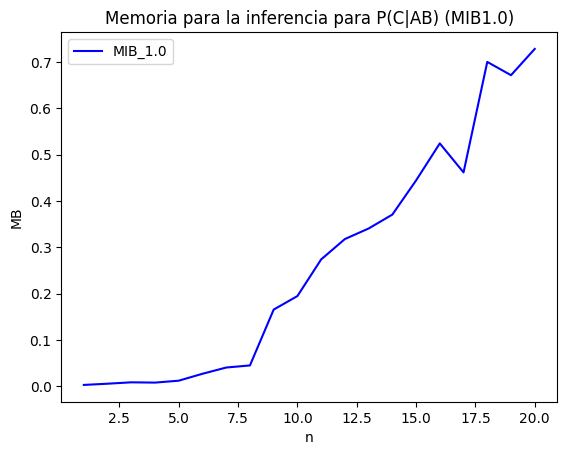

In [231]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, memoryC1, color='b',label = 'MIB_1.0')
ax.set_title("Memoria para la inferencia para P(C|AB) (MIB1.0)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

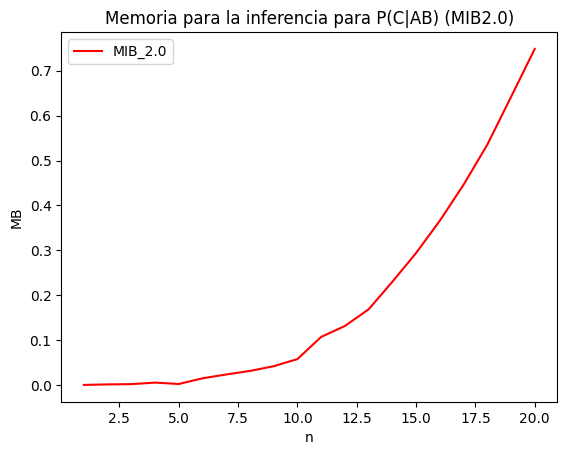

In [232]:
fig, ax = plt.subplots()

# MIB_2.0
ax.plot(xn, memoryC, color='r',label = 'MIB_2.0')
ax.set_title("Memoria para la inferencia para P(C|AB) (MIB2.0)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

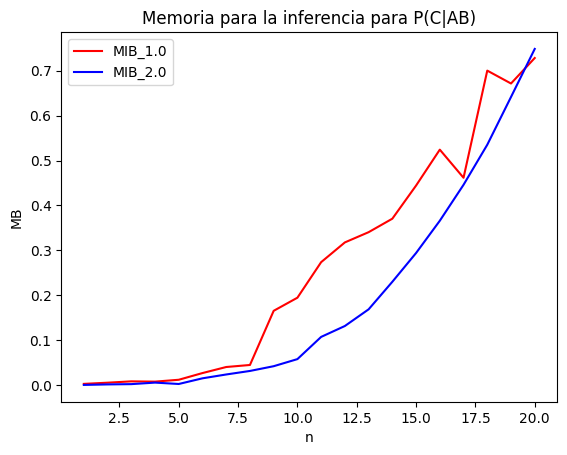

In [233]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, memoryC1, color='r',label = 'MIB_1.0')
# MIB_2.0
ax.plot(xn, memoryC, color='b',label = 'MIB_2.0')

ax.set_title("Memoria para la inferencia para P(C|AB)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

# Test 2

## Planteamineto

Se tiene un conjunto de correos, en los cuales se sabe si son spam o no, y se quiere saber si dada las palabras presentes en el correo el correo pertenece a spam.

### Variables

* $Spam := \{0,1\}$
* $W_i = \{0,1\}$

* $P(Spam = 0) = 0.25$
* $P(Spam = 1) = 0.75$

### Modelo de descomposición

#### Conjunta
$P(Spam W_0 W_1 ... W_n ) = P(Spam)\prod_i P(W_i|Spam)$.

Cada una de las $n$ formas de $P(W_i|Spam)$ debe ser espacificado. Para el conteo de la i-ésima palabra que aparesca spam y no spam 

* $P(W_i|Spam)$
    * $P(W_i = true | Spam = false) = \frac{1 + {n^i}_f}{|W_i| + n_f}$
    * $P(W_i = true | Spam = true) = \frac{1 + {n^i}_v}{|W_i| + n_t}$

donde, ${n^i}_f$ es el número de apariciones de la i-ésima palabra en correos que no son spam y $n_f$ es el número total de correos que no son spam, ${n^i}_v$ es el número de apariciones de la i-ésima palabra en correos que son spam y $n_v$ es el número total de correos que son spam.

## Implementación 

### Generación de distribuciones

#### $P(Spam)$

In [2]:
dSpam = {(0,):0.25, (1,):0.75}
# Variables para el motor de inferencia.
Spam = mb.Var('Spam',set([0,1]))
PSpam = mb.Distrib(set([Spam]), dSpam, (Spam.getName(),))
PSpam.print_table()

{(0,): 0.25, (1,): 0.75}


#### $W_i$

In [3]:
vocabulario = ['fortune','next','programming','money','you']
W = {}
events = set([0,1])

for palabra in vocabulario:
    W[palabra] = mb.Var(palabra, events)
    print(f'W[{palabra}]: {W[palabra]}')

W[fortune]: <mib_v2_3.Var object at 0x7fdec2d665b0>
W[next]: <mib_v2_3.Var object at 0x7fdec2d666a0>
W[programming]: <mib_v2_3.Var object at 0x7fdec2d66730>
W[money]: <mib_v2_3.Var object at 0x7fdec2d667f0>
W[you]: <mib_v2_3.Var object at 0x7fdec2d66850>


#### $P(W_i|Spam)$

In [4]:
nif = [0,125,250,0,125] #Canitdad de veces que aparece una palabra en correos que no son spam.
niv = [375,0,0,750,375] #Canitdad de veces que aparece una palabra en correos que son spam.

nf = 250
nv = 750

PWi_Spam = {}

i = 0
for Wi in W:
    tf = (1 + nif[i]) / (2 + nf)
    tt = (1 + niv[i]) / (2 + nv)
    dWi_Spam = {(0,): {(0,): 1 - tf, (1,):  tf},
                (1,): {(0,): 1 - tt, (1,): tt}}
    
    PWi_Spam[Wi] = mb.CondDistrib(set([W[Wi]]), set([Spam]), dWi_Spam, (W[Wi].getName(),), (Spam.getName(),))
    i += 1
for Wi in W:   
    PWi_Spam[Wi].print_table()

{(0,): {(0,): 0.996031746031746, (1,): 0.003968253968253968}, (1,): {(0,): 0.5, (1,): 0.5}}
{(0,): {(0,): 0.5, (1,): 0.5}, (1,): {(0,): 0.9986702127659575, (1,): 0.0013297872340425532}}
{(0,): {(0,): 0.003968253968253954, (1,): 0.996031746031746}, (1,): {(0,): 0.9986702127659575, (1,): 0.0013297872340425532}}
{(0,): {(0,): 0.996031746031746, (1,): 0.003968253968253968}, (1,): {(0,): 0.0013297872340425343, (1,): 0.9986702127659575}}
{(0,): {(0,): 0.5, (1,): 0.5}, (1,): {(0,): 0.5, (1,): 0.5}}


In [5]:
vars = set([W[i] for i in W] + [Spam])
distribs = set([PWi_Spam[i] for i in W] + [PSpam])
P_WiSpam = mb.Specification(vars, distribs)
Q_WiSpam = mb.Question(P_WiSpam)

In [14]:
inicio = time.time()
PSpam_wn = Q_WiSpam.DistributionQuery(set([W[wi] for wi in W]), set([Spam]))
fin = time.time()
tiempo_ejecucion = fin - inicio
PSpam_wn.print_table()

{(0,): {(0, 0, 0, 0, 0): 0.0009842055943482587, (0, 0, 0, 0, 1): 3.9211378260886795e-06, (0, 0, 0, 1, 0): 3.9211378260886795e-06, (0, 0, 0, 1, 1): 1.5622063052146134e-08, (0, 0, 1, 0, 0): 0.2470356041814138, (0, 0, 1, 0, 1): 0.000984205594348262, (0, 0, 1, 1, 0): 0.000984205594348262, (0, 0, 1, 1, 1): 3.921137826088693e-06, (0, 1, 0, 0, 0): 0.0009842055943482587, (0, 1, 0, 0, 1): 3.9211378260886795e-06, (0, 1, 0, 1, 0): 3.9211378260886795e-06, (0, 1, 0, 1, 1): 1.5622063052146134e-08, (0, 1, 1, 0, 0): 0.2470356041814138, (0, 1, 1, 0, 1): 0.000984205594348262, (0, 1, 1, 1, 0): 0.000984205594348262, (0, 1, 1, 1, 1): 3.921137826088693e-06, (1, 0, 0, 0, 0): 0.0009842055943482587, (1, 0, 0, 0, 1): 3.9211378260886795e-06, (1, 0, 0, 1, 0): 3.9211378260886795e-06, (1, 0, 0, 1, 1): 1.5622063052146134e-08, (1, 0, 1, 0, 0): 0.2470356041814138, (1, 0, 1, 0, 1): 0.000984205594348262, (1, 0, 1, 1, 0): 0.000984205594348262, (1, 0, 1, 1, 1): 3.921137826088693e-06, (1, 1, 0, 0, 0): 0.0009842055943482587

In [15]:
tiempo_ejecucion

0.012822389602661133

# Test 3

## Planteamiento

Una compañía sabe que la contratación profesional de un candidato se efectúa luego de una entrevista, que se lleva a cabo en función de las calificaciones reportadas en el certificado del candidato y si éste tiene experiencia laboral o no. Generalmente, sólo se consideran los candidatos con calificaciones sobresalientes o regulares, y la entrevista arroja típicamente tres tipos de apreciación.

La compañía ha elaborado el siguiente modelo de contratación:

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./MODELO_EMPRESA.jpg" width=300/>

La compañía ha recolectado datos históricos de los últimos 5 años sobre la evaluación de 500 candidatos y sabe que la proporción de candidatos con calificaciones regulares es del 30%, mientras que los candidatos con experiencia laboral representan el 60%. En la mejor condición, con calificaciones sobresalientes y experiencia laboral, los candidatos obtienen la más alta apreciación en la entrevista en un 80%, y la peor apreciación en un 2% de los casos. Estos porcentajes cambian respectivamente a 30% y 10% cuando las calificaciones no son las mejores, pero sí hay experiencia, y ambas son del 30% con calificaciones sobresalientes pero sin experiencia. En el peor caso, con calificaciones regulares y sin experiencia, los candidatos obtienen la mejor apreciación en la entrevista en un 10% y la peor en un 70%. Por último, se sabe que la tasa de candidatos rechazados es de un 10% cuando obtienen una apreciación favorable, un 60% cuando obtienen una apreciación regular, y un 99% cuando obtienen una apreciación desfavorable en la entrevista.

### Variables

* $C := \{0,1\}$, donde C representa las calificaciones; 0 si son calificaciones reguales, 1 otro caso.
* $E : = \{0,1\}$, donde E representa la experencia; 
* $N : = \{0,1,2\}$, donde  
* $O : = \{0,1\}$, donde

### Modelo de descomposición

#### Conjunta
$P(C E N O) = P(C)P(E)P(N|C E)P(N|O)$

## Implementación

In [16]:
E = mb.Var('E', set([0,1]))
C = mb.Var('C', set([0,1]))
O = mb.Var('O', set([0,1]))
N = mb.Var('N', set([0,1,2]))

dE = {(0,):0.4, (1,):0.6}
dC = {(0,):0.3, (1,):0.7}
dN_EC = {(0,0):{(0,):0.7, (1,):0.2, (2,):0.1},
        (0,1):{(0,):0.3, (1,):0.4, (2,):0.3},
        (1,0):{(0,):0.1, (1,):0.6, (2,):0.3},
        (1,1):{(0,):0.02, (1,):0.18, (2,):0.8}}
dO_N={(0,):{(0,):0.99, (1,):0.01},
      (1,):{(0,):0.6, (1,):0.4},
      (2,):{(0,):0.1, (1,):0.9}}

P_E = mb.Distrib(set([E]), dE, (E.getName(),))
P_C = mb.Distrib(set([C]), dC, (C.getName()))
P_N_EC = mb.CondDistrib(set([N]),set([E,C]), dN_EC, (N.getName(),), (E.getName(), C.getName()))
P_O_N = mb.CondDistrib(set([O]),set([N]), dO_N, (O.getName(),), (N.getName()))

In [17]:
#joint distribution
vars = set([E,C,N,O])
P_ECNO = mb.Specification(vars,set([P_E,P_C,P_N_EC,P_O_N]))

In [ ]:
#1. Cuál es su tasa de contratación 
#(i.e. cuál es la probabilidad de ser contratado). P(O)
Q_P = mb.Question(P_ECNO)
PO = Q_P.Marginal_Distrib(O)
print(PO.table)
CONT = PO.table[1]
print(f'{round(CONT*100,2)}%')

# Test 4
**Problema de autoria de textos**

## Planteamiento

## Especificación 

### Variables
- $A$ : Variable para los autores
- $T$ : Variable para los tipos de textos
- $W_I$ : Variable para las palabras

**Variable $A$**

- $A = $ Alfonso Reyes
- $A = $ Esopo
- $A = $ Fuentes
- $A = $ García Márquez
- $A = $ Gibran
- $A = $ La Fontanie
- $A = $ Onetti
- $A = $ Quiroga
- $A = $ Rulfo
- $A = $ Saramago

**Variable $T$**

- $T = $ minicuento
- $T = $ cuento
- $T = $ fábula

**Variable $W_i$**

- $W_i = \{0,1\}$, donde cada $W_i$ representa una variable para una palabra y sus representaciones númericas son las siguientes:
- $W_i = 0$ -> la palabra no esta.
- $W_i = 1$ -> la palabra si esta.

### Suponiendo un modelo de descomposición exacta:
$P(A)P(T|A)\displaystyle \prod_{i=0}^{n} P(W_i|AT)$

## Implementación 

In [1]:
import tpproc as tp
from collections import Counter  #regresa un diccionario con conteos
import glob
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import OrderedDict #diccionarios ordenados
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/roberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Obtención de datos para el test

In [2]:
archivos = glob.glob('./Train/*/*')
archivos,nombres = tp.carga_cuentos(archivos)
df_train = tp.lee_cuentos(archivos)
df_train.head()

leyendo...
tamaño del contenido de archivos cargados:             1 KB


,titulo,tipo,autor,texto
0,la sombra,minicuento,gibrán jalil gibrán,cierto día junio hierba dijo sombra olmo mueve...
1,la búsqueda,cuento,gibrán jalil gibrán,hace mil años dos filósofos encontraron cuesta...
2,dos poemas,cuento,gibrán jalil gibrán,varios siglos atrás camino atenas encontraron ...
3,"aquel viejo, viejo vino",cuento,gibrán jalil gibrán,vez hombre rico orgulloso bodega vino allí vas...
4,tres regalos,cuento,gibrán jalil gibrán,cierta vez ciudad becharre vivía amable prínci...


In [3]:
archivos = glob.glob('./Test/*')
archivos,nombres = tp.carga_cuentos(archivos)
df_test = tp.lee_cuentos(archivos,test=True)
df_test.head()

leyendo...
tamaño del contenido de archivos cargados:             0 KB


,titulo,texto
0,dos seres iguales,cierto día profeta sharía encontró niña jardín...
1,el león y el pastor,yendo león montaña erró camino pasando lugar l...
2,el caballo y el lobo,estación blandos céfiros hacen verdear campos ...
3,prisa,pesar torpor ojos hinchados aire recién salido...
4,la melancolía del viajero,veces vuelven largo viaje conservan toda vida ...


#### Data Frames de trabajo

In [4]:
s = df_train.texto.str.cat(sep=' ').split()
print(len(s))
conteos=Counter(s)
nuevo_vocabulario = list(set([palabra for palabra in s if conteos[palabra] <= 20 and conteos[palabra] >= 5 ]))
print(len(nuevo_vocabulario))

7210
237


In [5]:
df_train_T = df_train.copy()
df_train_T['nuevo_texto'] = df_train_T.texto.str.split().\
    apply(lambda texto: [w for w in texto if w in nuevo_vocabulario]).\
    apply(lambda x : ' '.join(x))
df_train_T['Conteos']=df_train_T.nuevo_texto.str.split().apply(Counter)


df_train_T.head()

,titulo,tipo,autor,texto,nuevo_texto,Conteos
0,la sombra,minicuento,gibrán jalil gibrán,cierto día junio hierba dijo sombra olmo mueve...,cierto hierba tan paz respondió hacia cielo ár...,"{'cierto': 1, 'hierba': 3, 'tan': 1, 'paz': 1,..."
1,la búsqueda,cuento,gibrán jalil gibrán,hace mil años dos filósofos encontraron cuesta...,hace años encontraron hacia dónde fuente respo...,"{'hace': 1, 'años': 1, 'encontraron': 1, 'haci..."
2,dos poemas,cuento,gibrán jalil gibrán,varios siglos atrás camino atenas encontraron ...,atrás camino encontraron cómo poeta respondió ...,"{'atrás': 1, 'camino': 1, 'encontraron': 1, 'c..."
3,"aquel viejo, viejo vino",cuento,gibrán jalil gibrán,vez hombre rico orgulloso bodega vino allí vas...,vino vasija vino sólo luego pensar vasija vasi...,"{'vino': 5, 'vasija': 5, 'sólo': 1, 'luego': 1..."
4,tres regalos,cuento,gibrán jalil gibrán,cierta vez ciudad becharre vivía amable prínci...,ciudad príncipe pobre príncipe príncipe prínci...,"{'ciudad': 1, 'príncipe': 11, 'pobre': 1, 'pue..."


In [6]:
s=df_test.texto.str.cat(sep=' ').split()
print(len(s))
conteos=Counter(s)
nuevo_vocab = list(set([palabra for palabra in s if conteos[palabra] <= 20 and conteos[palabra] >= 5]))
print(len(nuevo_vocab))

2224
64


In [7]:
df_test_T = df_test.copy()
df_test_T['nuevo_texto']=df_test_T.texto.str.split().\
    apply(lambda texto: [w for w in texto if w in nuevo_vocab]).\
    apply(lambda x : ' '.join(x))
df_test_T['nuevo_total']=df_test_T.nuevo_texto.str.split().apply(len)
df_test_T['Conteos']=df_test_T.nuevo_texto.str.split().apply(Counter)


df_test_T.head()

,titulo,texto,nuevo_texto,nuevo_total,Conteos
0,dos seres iguales,cierto día profeta sharía encontró niña jardín...,cierto día profeta niña niña dijo día señor pr...,57,"{'cierto': 1, 'día': 3, 'profeta': 7, 'niña': ..."
1,el león y el pastor,yendo león montaña erró camino pasando lugar l...,león mano así pastor mano pastor vio león past...,27,"{'león': 6, 'mano': 4, 'así': 1, 'pastor': 7, ..."
2,el caballo y el lobo,estación blandos céfiros hacen verdear campos ...,vida cierto alegría dijo así dijo todas aquel ...,13,"{'vida': 1, 'cierto': 1, 'alegría': 1, 'dijo':..."
3,prisa,pesar torpor ojos hinchados aire recién salido...,ojos nunca prisa siempre prisa día noche noche...,38,"{'ojos': 2, 'nunca': 2, 'prisa': 10, 'siempre'..."
4,la melancolía del viajero,veces vuelven largo viaje conservan toda vida ...,vida solo sitio todas ulises ulises así vida q...,28,"{'vida': 2, 'solo': 1, 'sitio': 1, 'todas': 1,..."


#### Tamaño del vocabulario conjunto (total de palabras)

In [8]:
vocabulario = list(set(nuevo_vocabulario+nuevo_vocab))
print(len(vocabulario))

271


In [9]:
voc_dict = OrderedDict(zip(vocabulario,range(len(vocabulario))))
v = list(voc_dict.keys())

#### Conteos

In [10]:
# Ocurrencias de cada autor y conteos de ocurrencias y de número de autores
oc_autor = Counter(df_train_T.autor)
tot_oc_aut = np.sum(list(oc_autor.values()))
tot_autores = len(oc_autor)

# Ocurrencias de cada tipo y conteos de ocurrencias y de número de tipos
oc_tipo = Counter(df_train_T.tipo)
tot_oc_tipo = np.sum(list(oc_tipo.values()))
tot_tipos = len(oc_tipo)

### Creación de variables

In [11]:
# Autor
autor_val = dict(zip(oc_autor.keys(),range(len(oc_autor.keys()))))
val_autor = dict(zip(range(len(oc_autor.keys())),oc_autor.keys()))
A = mb.Var('A',set(oc_autor.keys()))
# Tipos
tipo_val = dict(zip(oc_tipo.keys(),range(len(oc_tipo.keys()))))
val_tipo = dict(zip(range(len(oc_tipo.keys())),oc_tipo.keys()))
T = mb.Var('T',set(oc_tipo.keys()))

# Palabras
W = {}
for w in voc_dict:    # vocabulario reducido
    W[w] = mb.Var(w,set([0,1]))

NameError: name 'mb' is not defined

### Identificación de parámetros (estadísticas)

### Método:

1. Descomposición exacta: $P(A)P(T|A)P(W|AT)$
2. Calcular las estadísticas por cada distribución de la descomposición
3. Para la variable Autor $P(A)$:
    - 3.1 Contar el número total de ocurrencias de autores en Train: $n_a$.
    - 3.2 Contar el número de ocurrencias de cada autor en Train: $n^i$.
    - 3.3 Dividir este número entre el número total de ocurrencias de autores en Train: $\displaystyle \frac{n^i}{n_a}$.
4. Para la variable Tipo $P(T|A)$:
    - 4.1 Obtener el conjunto de autores (valores únicos) $a$; entradas a la Tabla.
    - 4.2 Obtener el conjunto de tipos (valores únicos) $j$; estas son las salidas de la Tabla.
    - 4.3 Calcular el producto cartesiano de las combinaciones posibles (a,j).
    - 4.4 Contar el número de ocurrencias totales de cada $j$ por cada autor: $n^j_a$.
    - 4.5 Dividir este número entre el número total de tipos por autor: $\displaystyle \frac{n^j_a}{\sum n^j_a}$.
    - 4.6 Aplicar la corrección de Laplace para evitar probabilidades en $0$.
5. Para las variables W (palabras) $P(W|AT)$: **NOTA** se trata de calcular N Tablas, donde N es el tamaño del vocabulario.
    - 5.1 Calcular el producto cartesiano de las combinaciones posibles (a,j); estas son las entradas a cada Tabla.
    - 5.2 Por cada combinación, calcular la probabilidad de cada palabra del vocabulario, en función de su ocurrencia en esa combinación, aplicando la corrección de Laplace. 

##### Distribución P(A)
- Contar el número total de ocurrencias de autores en Train: $n_a$: _tot_oc_aut_
- Contar el número de ocurrencias de cada autor en Train: $n^i$: _oc_autor_ 
- Dividir este número entre el número total de ocurrencias de autores en Train: $\displaystyle \frac{n^i}{n_a}$

In [ ]:
n_= []
for autor in oc_autor:
    n_.append(((autor,),oc_autor[autor]/tot_oc_aut))

#Dicionario de valores de probabilidad
dA = dict(n_)
#Distribución de probabilidad
PA = mb.Distrib(vars=set([A]), table = dA, columns=('A',))
print(A.getValues())
PA.print_table()

['carlos fuentes', 'juan carlos onetti', 'horacio quiroga', 'gabriel garcía márquez', 'juan rulfo', 'alfonso reyes', 'jean de la fontaine', 'esopo', 'gibrán jalil gibrán', 'josé saramago']
{('gabriel garcía márquez',): 0.13333333333333333, ('horacio quiroga',): 0.06666666666666667, ('carlos fuentes',): 0.06666666666666667, ('esopo',): 0.1, ('alfonso reyes',): 0.13333333333333333, ('jean de la fontaine',): 0.13333333333333333, ('gibrán jalil gibrán',): 0.16666666666666666, ('juan carlos onetti',): 0.06666666666666667, ('josé saramago',): 0.06666666666666667, ('juan rulfo',): 0.06666666666666667}


#### Distribución P(T|A)
   - Obtener el conjunto de autores (valores únicos) $a$; entradas a la Tabla: _df_train.autor_
   - Obtener el conjunto de tipos (valores únicos) $j$; estas son las salidas de la Tabla: _df_train.tipo_ 
   - Calcular el producto cartesiano de las combinaciones posibles (a,j): _pares_ta_
   - Contar el número de ocurrencias totales de cada $j$ por cada autor: $n^j_a$: _conteo_pares_
   - Dividir este número entre el número total de tipos por autor: $\displaystyle \frac{n^j_a}{\sum n^j_a}$.
   - Aplicar la corrección de Laplace para evitar probabilidades en $0$.

In [ ]:
# Ocurrencias (conteos) de cada combinación (tipo,autor)
conteo_pares = Counter(zip(df_train_T.autor,df_train_T.tipo))
# print(conteo_pares)

# Combinaciones (tipo,autor)
autores = list(set(df_train_T.autor))
tipos = list(set(df_train_T.tipo))

dT_A = {}

for autor, tipo in product(*[autores,tipos]):
    par = (autor, tipo)
    ak = (autor,)
    
    if ak in dT_A.keys():
        if par in conteo_pares.keys():
            dT_A[ak][(tipo,)] = conteo_pares[par]
        else:
            dT_A[ak][(tipo,)] = 0 
    else:
        if par in conteo_pares.keys():
            dT_A[ak] = {(tipo,): conteo_pares[par]}
        else:
            dT_A[ak] = {(tipo,): 0}


# Corrección de Laplace en el caso general
# Se corrige la misma tabla que se senvía como argumento; no se crea una nueva.
def Laplace_gral(tabla):
    n = len(tabla[list(tabla.keys())[0]]) 
    for k in tabla.keys():
        registro = tabla[k]
        n_j = np.sum(list(registro.values()))
        for i in registro.keys():
            pb = (registro[i] + 1)/(n_j+n)
            tabla[k][i]=pb
    return

Laplace_gral(dT_A)

PT_A = mb.CondDistrib(set([T]), set([A]), dT_A, (T.getName(),), (A.getName(),))

In [ ]:
PT_A.print_table()

{('carlos fuentes',): {('cuento',): 0.4, ('fábula',): 0.2, ('minicuento',): 0.4}, ('juan carlos onetti',): {('cuento',): 0.6, ('fábula',): 0.2, ('minicuento',): 0.2}, ('horacio quiroga',): {('cuento',): 0.6, ('fábula',): 0.2, ('minicuento',): 0.2}, ('gabriel garcía márquez',): {('cuento',): 0.2857142857142857, ('fábula',): 0.14285714285714285, ('minicuento',): 0.5714285714285714}, ('juan rulfo',): {('cuento',): 0.6, ('fábula',): 0.2, ('minicuento',): 0.2}, ('alfonso reyes',): {('cuento',): 0.14285714285714285, ('fábula',): 0.14285714285714285, ('minicuento',): 0.7142857142857143}, ('jean de la fontaine',): {('cuento',): 0.14285714285714285, ('fábula',): 0.14285714285714285, ('minicuento',): 0.7142857142857143}, ('esopo',): {('cuento',): 0.16666666666666666, ('fábula',): 0.6666666666666666, ('minicuento',): 0.16666666666666666}, ('gibrán jalil gibrán',): {('cuento',): 0.625, ('fábula',): 0.125, ('minicuento',): 0.25}, ('josé saramago',): {('cuento',): 0.4, ('fábula',): 0.2, ('minicuento

#### $P(W|AT)$
   - Calcular el producto cartesiano de las combinaciones posibles (a,j); estas son las entradas a cada Tabla.
   - Por cada combinación, calcular la probabilidad de cada palabra del vocabulario, en función de su ocurrencia en esa combinación, aplicando la corrección de Laplac

* Las palabras a tomar en cuenta son las del vocabulario.
* Se deben codificar las combinaciones (a,t) en valores numéricos.
* Por cada combinación (a,t):
    - si existe una historia (nuevo_texto), entonces cada palabra de este cuento está presente, y el resto de las palabras del vocabulario están ausentes.
    - si no hay historia, entonces ninguna palabra del vocabulario está presente --> Probabilidad 0 para todo el vocabulario.
* Al aplicar la corrección de Laplace, evitamos que una combinación (a,t), que por ahora no tiene texto, se considere imposible, al asignarle una probabilidad mínima a cada palabra del vocabulario.
* Para facilitar el "conteo" (presencia/ausencia) haremos un diccionario del vocabulario, incialmente en ceros

In [ ]:
# Combinaciones (tipo,autor)
autores = list(set(df_train_T.autor))
tipos = list(set(df_train_T.tipo))
pares_ta = list(product(autores,tipos))

# Conteos de palabras en nuevo_texto por pares (a,t) en el data frame de train
conteo_w = dict(df_train_T.Conteos)
pares_train = list(zip(df_train_T.autor,df_train_T.tipo))

for i,k in enumerate(conteo_w.keys()):
    conteo_w[k] = {pares_train[i] : dict(conteo_w[k])}
    
def check(palabra,pares_ta):
    pw_ = {}
    var = W[palabra]
    
    for par in pares_ta:
        cw_1 = 0   # conteos de presencia 
        cw_0 = 0   # y ausencia en 0
        it = 0     # total de pares (a,t) contabilizados
        
        for item in list(conteo_w.values()):  # checamos cada par (a,t) en el conjunto de train
            # print(i,list(item.keys())[0], end=' ')
            it += 1
            if par in item: # checamos si el par (a,t) de entrada tiene correspondencia en Train
                if palabra in list(item.values())[0]: #checamos si la palabra existe en el par (a,t) de Train
                    cw_1 += 1
                else:
                    cw_0 += 1  #debemos contar también la no existencia por si hay igualdad
        
        if cw_0 == cw_1: # la palabra aparece por igual en todos los pares Train, o bien, no hay pares Train
            pw_1 = 0.5   #corrección de Laplace que indica que la palabra puede o no estar por igual
            pw_0 = 0.5
            
        else:
            pw_1=(1+cw_1)/(len(var.getValues())+it) #corrección de Laplace en caso de que la palabra exista
            pw_0 = 1-pw_1
        
        pw_[par] = {(0,): pw_0, (1,): pw_1}
    pw_ = OrderedDict(sorted(pw_.items()))
    return pw_
        
    
PW_AT = {}
for w in voc_dict:    # vocabulario reducido
    t = check(w,pares_ta)
    PW_AT[w] = mb.CondDistrib(set([W[w]]),set([A,T]), dict(t), (W[w].getName(),), (A.getName(), T.getName()))

In [ ]:
palabra = list(PW_AT.keys())[0]
print(palabra+':')
PW_AT[list(PW_AT.keys())[0]].print_table()

sitio:
{('alfonso reyes', 'cuento'): {(0,): 0.5, (1,): 0.5}, ('alfonso reyes', 'fábula'): {(0,): 0.5, (1,): 0.5}, ('alfonso reyes', 'minicuento'): {(0,): 0.96875, (1,): 0.03125}, ('carlos fuentes', 'cuento'): {(0,): 0.96875, (1,): 0.03125}, ('carlos fuentes', 'fábula'): {(0,): 0.5, (1,): 0.5}, ('carlos fuentes', 'minicuento'): {(0,): 0.96875, (1,): 0.03125}, ('esopo', 'cuento'): {(0,): 0.5, (1,): 0.5}, ('esopo', 'fábula'): {(0,): 0.96875, (1,): 0.03125}, ('esopo', 'minicuento'): {(0,): 0.5, (1,): 0.5}, ('gabriel garcía márquez', 'cuento'): {(0,): 0.96875, (1,): 0.03125}, ('gabriel garcía márquez', 'fábula'): {(0,): 0.5, (1,): 0.5}, ('gabriel garcía márquez', 'minicuento'): {(0,): 0.96875, (1,): 0.03125}, ('gibrán jalil gibrán', 'cuento'): {(0,): 0.96875, (1,): 0.03125}, ('gibrán jalil gibrán', 'fábula'): {(0,): 0.5, (1,): 0.5}, ('gibrán jalil gibrán', 'minicuento'): {(0,): 0.96875, (1,): 0.03125}, ('horacio quiroga', 'cuento'): {(0,): 0.96875, (1,): 0.03125}, ('horacio quiroga', 'fábul

In [ ]:
vl =  [A,T] + [W[w] for w in W] 
dl = [PA,PT_A] + [PW_AT[w] for w in PW_AT]
vars_set = set(vl)
dist_set = set(dl)

## Pregutas 

In [45]:
PATWi = mb.Specification(vars_set, dist_set)
QW_AT = mb.Question(PATWi)

1. ¿Quién escribió "El caballo y el Lobo"?

In [47]:
dcont = df_test_T.loc[df_test['titulo'] == 'el caballo y el lobo', 'Conteos'].iloc[0]
wit = []
for w in dcont:
    wit.append(w)

In [48]:
values_wi = []
wi = tuple([W[w] for w in W])
for w in wi:
    if w.getName() in wit:
        values_wi.append(1)
    else:
        values_wi.append(0)

- $W = \text{ todas las palabras}$
- $Wt = \text{ palabras que esten en el texto}$
- $Wnt = \text{ palabras que no esten en el texto}$
- $W_i = 0 \text{ si } w_i \in wnt$
- $W_i = 1 \text{ si } w_i \in wt$

**Pregunta:**
$ P(A | W_0, W_1, \dots, W_n) $, donde se busca el valor más probable de $A$.

In [49]:
CA, VA, p = QW_AT.Query(vars=(A,), indep=wi, values_indep=tuple(values_wi))
VA, p

(('jean de la fontaine',), 0.3783174150680577)

In [50]:
Wt = []
Wt_v = []

for w in wit:
    Wt.append(W[w])819606,
    Wt_v.append(1)

In [ ]:
k = len(W) + 2 - len(Wt_v)
print('10^',k)

In [53]:
CA, VA, p = QW_AT.Query(vars=(A,), indep=tuple(Wt), values_indep=tuple(Wt_v))

KeyboardInterrupt: 

In [ ]:
VA, p